In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
# some variables
DATA_FOLDER = 'data/'
nn_batches_amount = 20
output_size_amount = 10
input_size_amount = 64
learning_rate_amount = 0.001

In [3]:
# import mnist data using pytorch
from torchvision import datasets, transforms

# raw data
raw_training_data = datasets.FashionMNIST(DATA_FOLDER, download=True, train=True)
raw_testing_data = datasets.FashionMNIST(DATA_FOLDER, download=True, train=False)

HELPER FUNCTIONS

In [4]:
import numpy as np

# creating a training set from the raw data"
def get_training_set():
    training_set = np.empty([len(raw_training_data), 28*28], dtype=np.float32)
    training_labels = np.empty([len(raw_training_data)], dtype=np.int8)

    for k, data in enumerate(raw_training_data):
        training_set[k] = np.asarray(data[0]).reshape(28*28)
        training_labels[k] = np.int8(data[1])
    return training_set, training_labels

# creating a testing set from the raw data"
def get_testing_set():
    testing_set = np.empty([len(raw_testing_data), 28*28], dtype=np.float32)
    testing_labels = np.empty([len(raw_testing_data)], dtype=np.int8)

    for k, data in enumerate(raw_testing_data):
        testing_set[k] = np.asarray(data[0]).reshape(28*28)
        testing_labels[k] = np.int8(data[1])
    return testing_set, testing_labels

In [5]:
# takes the data and shuffles them and puts them into batches
def get_data_shuffled_and_in_batches(data, labels, batch_size):
    amt = len(data) / batch_size
    sh = np.random.permutation(np.arange(len(data)))
    return (np.array_split(data[sh], amt), np.array_split(labels[sh], amt))

# gets training data
def get_training_data(batch_size):
    d, l = get_training_set()
    return get_data_shuffled_and_in_batches(d, l, batch_size)

# gets the testing data
def get_testing_data(batch_size):
    d, l = get_testing_set()
    return get_data_shuffled_and_in_batches(d, l, batch_size)

# given index returns string label
def get_name(ci):
    return datasets.FashionMNIST.classes[ci]

# returns a class name
def get_class_name(c):
    return type(c).__name__

# Neural Network Class/Template
ACTIVATION FUNCTIONS

In [6]:
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
class ReLU():
    def forward(self, z):
        return np.maximum(0, z)

    def backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ

class Sigmoid():
    def forward(self, z):
        z = np.clip(z, 1e-7, 1-1e-7)
        return 1 / (1 + np.exp(-z))
        
    def backward(self, dA, z):
        sig = self.forward(z)
        return dA * sig * (1 - sig)

# http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
# https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
class LogSoftmax():
    def forward(self, z):
        c = z.max(axis=1)
        log_sum =  c + np.log(np.exp(z-c.reshape((-1, 1))).sum(axis=1))
        return z - log_sum.reshape((-1, 1))
        
    def backward(self, out, z):
        return out - np.exp(z)*out.sum(axis=1).reshape((-1, 1))

LAYER

In [7]:
# Layer
class Layer():

    # initialize the Layer
    def __init__(self, input_size, output_size, activation_func=None):
        self.weights = 0.01 * np.random.randn(input_size, output_size)
        self.biases = 0.01 * np.zeros((1, output_size))
        self.activation_func = activation_func

    def forward(self, inputs):
        return np.dot(inputs, self.weights) + self.biases

    def update(self, learning_rate, gweights, gbiases):
        self.weights -= learning_rate * gweights
        # self.biases -= learning_rate * gbiases

NETWORK MODEL

In [8]:
# network model
class Neural_Network_Model():
    def parameters(self):
        parameters = []
        for p in self.__dict__:
            parameters.append(getattr(self, p))
        return parameters

SGD Optimizer

In [9]:
from tqdm import tqdm

class SGD_Optimizer():

    # initializing
    def __init__(self, parameters):
        self.parameters = parameters
        self.parameters_amt = len(parameters)
        self.astages = [None] * (self.parameters_amt + 1)   # As
        self.learning_rate = 0.01  # default learning rate


    # full forward pass
    def forward(self, image):
        t = image
        self.astages[0] = t
        for k in range(self.parameters_amt):
            layer = self.parameters[k]
            t = layer.forward(t)
            if layer.activation_func != None:
                t = layer.activation_func.forward(t)
                self.astages[k+1] = t
        return t # output

    # full backward pass
    def backward(self, labels):
        
        # 1 hot
        out = np.zeros((len(labels), 10), np.float32)
        out[range(out.shape[0]), labels] = 1

        # the delta
        deltaLayer = -out / labels.shape[0]

        for k in reversed(range(self.parameters_amt)):
            layer = self.parameters[k]
            current_activation = self.astages[k+1]
            previous_activation = self.astages[k]
            deltaActivation = layer.activation_func.backward(deltaLayer, current_activation)
            deltaLayer = deltaActivation.dot(layer.weights.T)
            gradWeights = previous_activation.T.dot(deltaActivation)
            gradBiases = np.sum(deltaActivation, axis=1, keepdims=True) # [20,10] -> [1,10]

            # SGD
            layer.update(self.learning_rate, gradWeights, gradBiases)

    # calculates train accuracy
    @staticmethod
    def calculate_accuracy(preds, labels):
        return sum([np.argmax(p) == l for p, l in zip(preds, labels)])/len(labels)

    # training/fit
    def train(self, X_train, y_train, epochs, loss=None, learning_rate=None):
        
        # update learning rate
        if learning_rate is not None:
            self.learning_rate = learning_rate

        # history
        hist = np.zeros(epochs)

        # train
        for epoch in tqdm(range(epochs)):
            
            # store losses -> batch size
            batch_size = len(X_train)
            batch_losses = np.zeros(batch_size)
            batch_accuracies = np.zeros(batch_size)

            for i, (images, labels) in enumerate(zip(X_train, y_train)):

                # forward -> calculate accuracy
                out = self.forward(images.reshape(-1, 28*28))
                batch_accuracies[i] = self.calculate_accuracy(out, labels)

                # calculate loss
                if loss is not None:
                    batch_losses[i] = loss.calc_loss(out, labels)

                # backward
                self.backward(labels)

            # update mean loss and add average accuracies
            hist[epoch] = np.sum(batch_accuracies)/batch_accuracies.size
            loss.losses_per_epoch.append(np.mean(batch_losses))
            
        # return history
        return hist


MSE Loss Function

In [10]:
# MSE Loss function
class MSELoss:
  def __init__(self):
    self.losses_per_epoch = []
  
  def calc_loss(self, out, labels):
    preds = np.array([np.argmax(o) for o in out])
    return np.mean(np.square(np.subtract(preds, np.array(labels))))

## Our Neural Network
Creating the Network and training with SGD Optimizer and MSE Loss

In [11]:
np.random.seed(20)

# network
class Network(Neural_Network_Model):
    def __init__(self):
        self.hl1 = Layer(28*28, 128, ReLU())
        self.hl3 = Layer(128, 128, ReLU())
        self.hl3 = Layer(128, 64, ReLU())
        self.hl4 = Layer(64, 32, ReLU())
        self.hl5 = Layer(32, 10, LogSoftmax())

network = Network()

# loss and optimizer
loss = MSELoss()
optimizer = SGD_Optimizer(network.parameters())

Training the Model

In [12]:
# data
X_train, y_train = get_testing_data(nn_batches_amount)
X_test, y_test = get_testing_data(nn_batches_amount)

# train
history = optimizer.train(X_train, y_train, 60, learning_rate=0.001, loss=loss)

100%|██████████| 60/60 [00:34<00:00,  1.76it/s]


# Analysis

Predict using the Testset

In [13]:
# Prediction on Test Set
y_pred = []
correct_predictions = 0
amount = 0

for images, labels in zip(X_test, y_test):
    batch_pred = []

    for out, actual in zip(optimizer.forward(images.reshape(-1,28*28)), labels):
        pred = np.argmax(out)
        batch_pred.append(pred)
        amount += 1
        if pred == actual:
            correct_predictions += 1
    y_pred.append(batch_pred)

test_set_accuracy = correct_predictions/amount

# test
print(f"Accuracy on testset {test_set_accuracy}%")

Accuracy on testset 0.9342%


Accuracy x Loss Graph

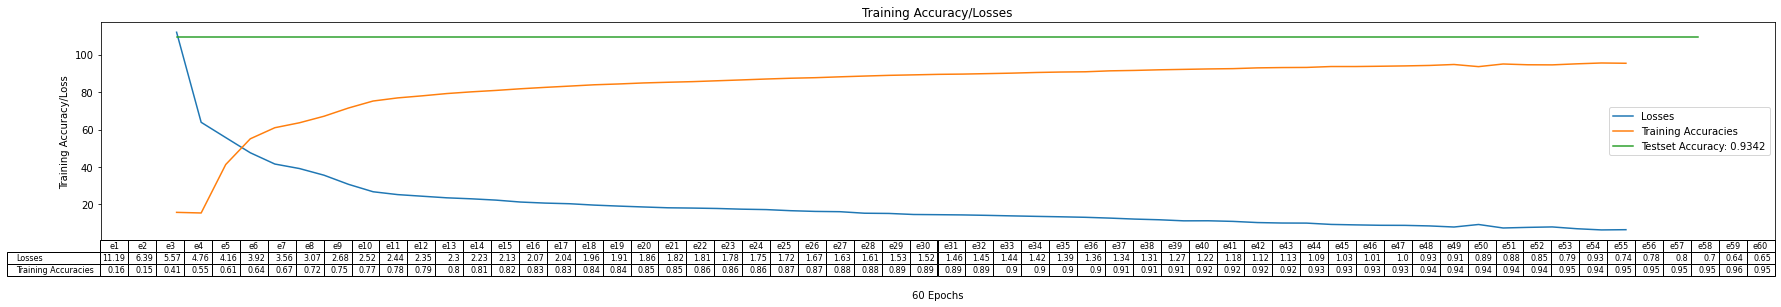

In [14]:
import matplotlib.pyplot as plt

# setup
fig, ax = plt.subplots(1, figsize=(30, 4))
ax.set_xticks([])
ax.set_title('Training Accuracy/Losses')
ax.set_xlabel(f'{history.size} Epochs', labelpad=50)
ax.set_ylabel('Training Accuracy/Loss')

# lines
line1, = ax.plot([l*10 for l in loss.losses_per_epoch], label='Losses')
line2, = ax.plot(history*100, label='Training Accuracies')
y_min, y_max = ax.get_ylim()
accuracy_y = y_max*test_set_accuracy
line3, = ax.plot([0, ax.get_xlim()[1]], [accuracy_y, accuracy_y], label=f'Testset Accuracy: {test_set_accuracy}')
ax.legend(handles=[line1, line2, line3])

# table
cols = [f'e{i+1}' for i in range(history.size)]
rows = ('Losses', 'Training Accuracies')
ax.table(cellText=(np.round(loss.losses_per_epoch, 2), np.round(history, 2)), rowLabels=rows, colLabels=cols, loc='bottom')

# display
plt.show()

Metrics on Test set

In [15]:
import sklearn.metrics as metrics

# ravel
y_test_raveled = np.array([batch for batch in y_test]).reshape(-1)
y_pred_raveled = np.array([batch for batch in y_pred]).reshape(-1)

print(metrics.classification_report(y_test_raveled, y_pred_raveled))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.88      0.89      1000
           3       0.92      0.94      0.93      1000
           4       0.84      0.92      0.88      1000
           5       1.00      0.99      0.99      1000
           6       0.83      0.81      0.82      1000
           7       0.99      0.97      0.98      1000
           8       1.00      0.99      0.99      1000
           9       0.97      1.00      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



Precision Bar

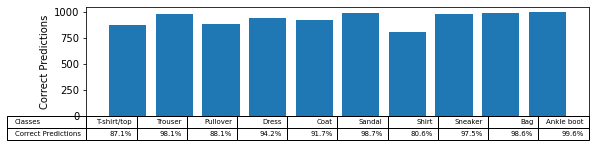

In [16]:
# precision
p_amt = np.zeros(10)
for l, p in zip(y_test_raveled, y_pred_raveled):
    if l == p:
        p_amt[l] += 1
p_amt = p_amt
fig, ax = plt.subplots(figsize=(9, 2))
ax.bar(range(10), p_amt)
ax.set_xticks([])
ax.set_ylabel('Correct Predictions')
ax.table(cellText=(([get_name(i) for i in range(10)], [f'{p/10}%' for p in p_amt])), rowLabels=['Classes', 'Correct Predictions'], loc='bottom')

# display
plt.show()

Simple Visualisation

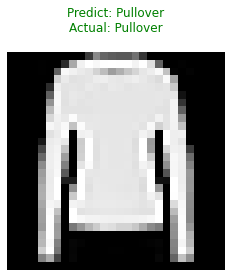

In [17]:
i = 1238

# imaple
image = np.array(raw_testing_data[i][0])
label = np.array(raw_testing_data[i][1])

# prediction
out = optimizer.forward(image.reshape(-1, 28*28))
pred = np.argmax(out)

# show result
ax = plt.imshow(np.int16(image), cmap='gray').axes
ax.set_title(f'Predict: {get_name(pred)}\nActual: {get_name(label)}\n', color='g' if pred == label else 'r')
ax.set_axis_off()

# display
plt.show()

### Let's evaluate on custom images

Images were published under the Creative Commons Attribution 2.0 Generic<br>Original Image Links: https://www.flickr.com/photos/44392817@N02/7222424346 , https://www.flickr.com/photos/55609681@N06/5552340881<br>Access Data: 16/08/22

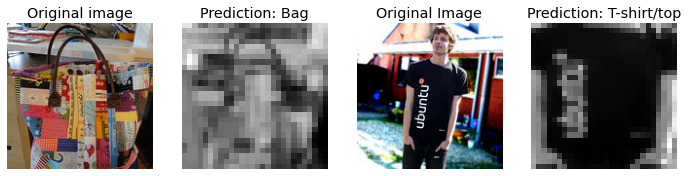

In [20]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.transform import resize, rotate

fig, ax = plt.subplots(1, 4, figsize=(12, 3))

og_img = imread('bag_img.jpg')
img = resize(og_img, (28, 28))
img = rgb2gray(img)
pred1 = np.argmax(optimizer.forward(img.reshape(-1, 28*28)))

ax[0].imshow(og_img)
ax[0].set_title('Original image', fontsize='x-large')
ax[0].set_axis_off()

ax[1].imshow(img, cmap='gray')
ax[1].set_title(f'Prediction: {get_name(pred1)}', fontsize='x-large')
ax[1].set_axis_off()

# Let's try out an image with someone wearing a tshirt
og_img = imread('tshirt_man.jpg')
img = rotate(og_img, 8)  # rotate the image
img = img[40:130,54:105]  # crop the image
img = resize(img, (28, 28))
img = rgb2gray(img)
pred2 = np.argmax(optimizer.forward(img.reshape(-1, 28*28)))

ax[2].imshow(og_img)
ax[2].set_title('Original Image', fontsize='x-large')
ax[2].set_axis_off()

ax[3].imshow(img, cmap='gray')
ax[3].set_title(f'Prediction: {get_name(pred2)}', fontsize='x-large')
ax[3].set_axis_off()

plt.show()